In [45]:
import pandas as pd
import numpy as np
import json
import pandas as pd
from cobra import Model, Reaction, Metabolite
from cobra.flux_analysis import flux_variability_analysis
import pickle
from tqdm import tqdm 
from ast import literal_eval
import cobra
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
from functools import partial 
import numpy as np
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
import plotly.io as pio
import plotly.graph_objects as go
import gurobipy
gurobipy.setParam('OutputFlag', 0)
import sys
sys.path.append('../retrosynthesis/')

from common import *


### input and output

In [46]:
###input
yeast870_path =  '../../Data/model/yeast-GEM.yml'
yeast8U_path = '../../Data/model/Yeast-MetaTwin.yml'
yeast8U_lipid_path = '../../Data/model/Yeast-MetaTwin-lipid.yml'


###output
source_fig2a_path = '../../Results/source_data/fig2-a.csv'
compare_yeast8_yeast8U_basic_info_figure_path = '../../Results/Figures/fig2-a.pdf'
ymdb_metabolites_sankey_result_figure_path = '../../Results/Figures/fig2-b.pdf'

In [47]:
def compare_yeast8_yeast8U_basic_info(yeast870_path,yeast8U_path,yeast8U_lipid_path,source_fig2a_path):
    yeast8 = cobra.io.load_yaml_model(yeast870_path)
    yeast8U = cobra.io.load_yaml_model(yeast8U_path)
    yeast8U_lipid = cobra.io.load_yaml_model(yeast8U_lipid_path)
    yeast8gene=len(yeast8.genes)
    yeast8metabolite=len(yeast8.metabolites)
    yeast8reaction=len(yeast8.reactions)
    yeast8Ugene=len(yeast8U.genes)
    yeast8Umetabolite=len(yeast8U.metabolites)
    yeast8Ureaction=len(yeast8U.reactions)
    yeast8U_lipidgene=len(yeast8U_lipid.genes)
    yeast8U_lipidmetabolite=len(yeast8U_lipid.metabolites) + 3200
    yeast8U_lipidreaction=len(yeast8U_lipid.reactions)

    
    res = {'Genes':[],
            'Metabolites':[],
            'Reactions':[]}
    res['Genes'].append(yeast8gene)
    res['Genes'].append(yeast8Ugene)
    res['Genes'].append(yeast8U_lipidgene)
    res['Metabolites'].append(yeast8metabolite)
    res['Metabolites'].append(yeast8Umetabolite)
    res['Metabolites'].append(yeast8U_lipidmetabolite)
    res['Reactions'].append(yeast8reaction)
    res['Reactions'].append(yeast8Ureaction)
    res['Reactions'].append(yeast8U_lipidreaction)
    res = pd.DataFrame(res)
    res.index = ['Yeast8','Yeast-MetaTwin-no-lipid','Yeast-MetaTwin-Lipid']
    res.to_csv(source_fig2a_path)
    res

In [48]:
compare_yeast8_yeast8U_basic_info(yeast870_path,yeast8U_path,yeast8U_lipid_path,source_fig2a_path)

In [49]:
def draw_fig2a(source_fig2a_path, compare_yeast8_yeast8U_basic_info_figure_path):
    # Read data from CSV file
    data = pd.read_csv(source_fig2a_path, index_col=[0])
    labels = ['Genes', 'Metabolites', 'Reactions']
    yeast8_data = data.loc['Yeast8', :].to_list()
    yeast8U_nonlipids_data = data.loc['Yeast-MetaTwin-no-lipid', :].to_list()
    yeast8U_lipids_data = data.loc['Yeast-MetaTwin-Lipid', :].to_list()

    # Plot configuration
    plt.figure(figsize=(1.8, 2), dpi=400)
    plt.rcParams.update({'font.size': 8})
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['pdf.fonttype'] = 42

    # Axis styling
    plt.gca().spines['top'].set_linewidth(0.5)
    plt.gca().spines['bottom'].set_linewidth(0.5)
    plt.gca().spines['left'].set_linewidth(0.5)
    plt.gca().spines['right'].set_linewidth(0.5)

    # Adjust plot margins
    plt.subplots_adjust(left=0.3, right=0.98, top=0.95, bottom=0.23)

    # Plotting data
    x = np.arange(len(labels))
    width = 0.3

    # Plot yeast8 bars
    bars1 = plt.bar(x - width / 2, yeast8_data, width=width, color='#e41a1c', edgecolor='black', linewidth=0.5, label='Yeast8')

    # Stack yeast8U (non-lipids) bars on top of yeast8 bars
    bars2 = plt.bar(x + width / 2, yeast8U_nonlipids_data, width=width, color='#377eb8', edgecolor='black', linewidth=0.5, label='Yeast-MetaTwin\n(Non-lipids)')

    # Stack yeast8U (lipids) bars on top of yeast8U (non-lipids) bars
    bars3 = plt.bar(x + width / 2, yeast8U_lipids_data, width=width, bottom=yeast8U_nonlipids_data, color='#4daf4a', edgecolor='black', linewidth=0.5, label='Yeast-MetaTwin\n(Lipids)')

    # Axes and legend
    # plt.xticks(x, labels, fontsize=6, rotation=60)
    plt.xticks(x, labels, fontsize=7)

    plt.yticks(fontsize=7)
    plt.tick_params(axis='both', direction='in', width=0.5, which='both', length=2)
    plt.ylim(0, 20000)
    # plt.ylim(0, 60000)
    plt.ylabel('Counts', fontsize=7)

    # Add legend and specify coordinates
    legend = plt.legend(frameon=False, fontsize=7, loc='upper left', bbox_to_anchor=(-0.04, 1.02), labelspacing=0.5, handletextpad=0.3)

    # Save and show the plot
    plt.savefig(compare_yeast8_yeast8U_basic_info_figure_path, dpi=400)
    plt.show()

In [50]:
data = pd.read_csv(source_fig2a_path, index_col=[0])
data

,Genes,Metabolites,Reactions
Yeast8,1163,2806,4131
Yeast-MetaTwin-no-lipid,2056,3301,7510
Yeast-MetaTwin-Lipid,2056,18695,58850


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def draw_fig2a(source_fig2a_path, compare_yeast8_yeast8U_basic_info_figure_path):
    # Read data from CSV file
    data = pd.read_csv(source_fig2a_path, index_col=[0])
    
    # Define and reverse the labels and data
    labels = ['Reactions', 'Metabolites', 'Genes']
    yeast8_data = data.loc['Yeast8', ::-1].to_list()
    yeast8U_nonlipids_data = data.loc['Yeast-MetaTwin-no-lipid', ::-1].to_list()
    yeast8U_lipids_data = data.loc['Yeast-MetaTwin-Lipid', ::-1].to_list()
    # yeast8U_lipids_data = [11000, 9000, 30]
    yeast8U_lipids_data[0] = yeast8U_lipids_data[0]-yeast8U_nonlipids_data[0]
    yeast8U_lipids_data[1] = yeast8U_lipids_data[1]-yeast8U_nonlipids_data[1]
    yeast8U_lipids_data[2] = yeast8U_lipids_data[2]-yeast8U_nonlipids_data[2]


    # Plot configuration
    plt.figure(figsize=(2.5, 1.3), dpi=400)
    plt.rcParams.update({'font.size': 7})
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['pdf.fonttype'] = 42

    # Axis styling
    plt.gca().spines['top'].set_linewidth(0.5)
    plt.gca().spines['bottom'].set_linewidth(0.5)
    plt.gca().spines['left'].set_linewidth(0.5)
    plt.gca().spines['right'].set_linewidth(0.5)

    # Adjust plot margins
    plt.subplots_adjust(left=0.3, right=0.95, top=0.98, bottom=0.15)

    # Plotting data
    y = np.arange(len(labels))
    height = 0.2

    # Plot yeast8 bars
    bars1 = plt.barh(y + height / 2, yeast8_data, height=height, color='#e41a1c', edgecolor='black', linewidth=0.5, label='Yeast8')

    # Stack yeast8U (non-lipids) bars on top of yeast8 bars
    bars2 = plt.barh(y - height / 2, yeast8U_nonlipids_data, height=height, color='#377eb8', edgecolor='black', linewidth=0.5, label='Yeast-MetaTwin(Non-lipids)')

    # Stack yeast8U (lipids) bars on top of yeast8U (non-lipids) bars
    bars3 = plt.barh(y - height / 2, yeast8U_lipids_data, height=height, left=yeast8U_nonlipids_data, color='#4daf4a', edgecolor='black', linewidth=0.5, label='Yeast-MetaTwin(Lipids)')

    # Axes and legend
    plt.yticks(y, labels, fontsize=7)
    plt.xticks(fontsize=7)
    plt.tick_params(axis='x', direction='in', width=0.5, which='both', length=2)
    plt.tick_params(axis='y', direction='out', width=0.5, which='both', length=1)
    plt.xlim(0, 60000)
    plt.xlabel('Counts', fontsize=7)
    plt.ylim(-0.5, 2.5)

    # Add legend and specify coordinates
    legend = plt.legend(frameon=False, fontsize=7, loc='upper right', bbox_to_anchor=(1.05, 1.02), labelspacing=0.5, handletextpad=0.3)

    # Save and show the plot
    plt.savefig(compare_yeast8_yeast8U_basic_info_figure_path, dpi=400, bbox_inches='tight')
    plt.show()

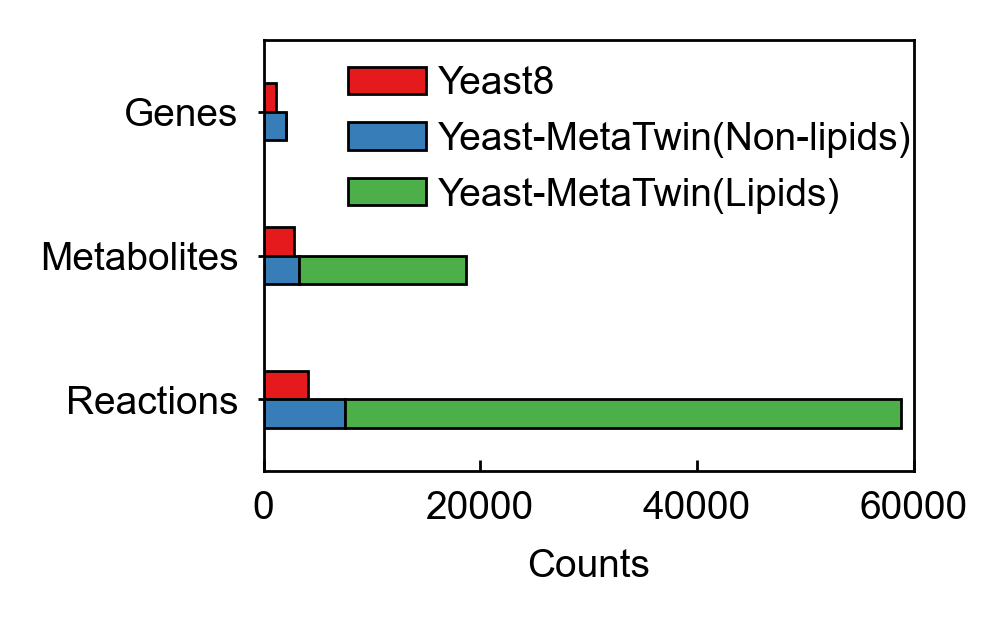

In [70]:
draw_fig2a(source_fig2a_path,compare_yeast8_yeast8U_basic_info_figure_path)

# sankey

In [67]:
# 215(nonlipids) + 51(uptake) + 6(noec nonlipids)+ 11986(lipids) + 1350(lipids)
print(215+6+51)
print(11986 + 1350)
print(215 + 6 + 51 + 11986 + 1350)
215 + 6 + 51 + 11986 + 1350 + 1160

272
13336
13608


14768

In [68]:
(572-272) + (14310 - 13336)

1274

In [66]:
14310 + 572

14882

In [71]:
# Create a Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=50,
        thickness=13,
        line=dict(color='black', width=0),
        label=['', '', '', '', '', ''],  # Leave node labels empty
        x=[0.06, 0.06, 0.38, 0.38, 0.70, 0.70],  # Set horizontal positions of nodes
        y=[0.84, 0.40, 0.384, 0.77, 0.53, 0.08],  # Set vertical positions of nodes
        color=['#e41a1c', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#f781bf']  # Set colors for each node
    ),
    link=dict(
        source=[0, 1, 1, 2, 2, 3, 3],
        target=[4, 2, 3, 4, 5, 4, 5],
        value=[1160, 14310, 572, 13336, 974, 272, 300],
    )
)])

# Add annotations to manually specify label positions
annotations = [
    dict(x=0.08, y=0.17, text='In Yeast8', showarrow=False, xanchor='left', font=dict(color='black', size=11)),
    dict(x=0.08, y=0.10, text='1160', showarrow=False, xanchor='left', font=dict(color='black', size=11)),

    dict(x=0.08, y=0.57, text='Not in Yeast8', showarrow=False, xanchor='left', font=dict(color='black', size=11)),
    dict(x=0.08, y=0.50, text='14882', showarrow=False, xanchor='left', font=dict(color='black', size=11)),

    dict(x=0.40, y=0.62, text='Lipids', showarrow=False, xanchor='left', font=dict(color='black', size=11)),
    dict(x=0.40, y=0.55, text='14310', showarrow=False, xanchor='left', font=dict(color='black', size=11)),

    dict(x=0.40, y=0.23, text='Non-lipids', showarrow=False, xanchor='left', font=dict(color='black', size=11)),
    dict(x=0.40, y=0.16, text='572', showarrow=False, xanchor='left', font=dict(color='black', size=11)),

    dict(x=0.72, y=0.47, text='In Yeast-MetaTwin', showarrow=False, xanchor='left', font=dict(color='black', size=11)),
    dict(x=0.72, y=0.40, text='14768', showarrow=False, xanchor='left', font=dict(color='black', size=11)),

    dict(x=0.72, y=0.96, text='Others', showarrow=False, xanchor='left', font=dict(color='black', size=11)),
    dict(x=0.72, y=0.89, text='1274', showarrow=False, xanchor='left', font=dict(color='black', size=11)),

    # New vertical text annotation
    dict(x=-0.02, y=0.17, text='Yeast metabolome database', showarrow=False, xanchor='left', font=dict(color='black', size=11), textangle=270)
]

fig.update_layout(
    font_size=14,
    margin=dict(l=5, r=60, t=10, b=0),  # Set plot margins
    font=dict(family='Arial'),  # Set font
    width=1.2 * 300,  # Set plot width, scaled to consistent units (e.g., 100 pixels per inch)
    height=0.7 * 300,  # Set plot height, scaled to consistent units
    annotations=annotations  # Add custom annotations
)

# Save the plot as a PDF
pio.write_image(fig, file=ymdb_metabolites_sankey_result_figure_path)
fig.show()